```{currentmodule} tskit
```

In [1]:
import msprime
import tskit
import numpy as np

def basics():
    # Use "record full ARG" so we can get a nice SPR animation if we want it at the end
    # random_seed picked to get 2nd SPR involving 2 edges only (at the root)
    arg = msprime.sim_ancestry(
        3,
        population_size=100,
        random_seed=1440,
        sequence_length=1000,
        recombination_rate=1e-6,
        record_full_arg=True)
    arg = msprime.sim_mutations(arg, rate=1e-6, random_seed=23)
    ts = arg.simplify()
    tables = ts.dump_tables()
    # populations already has a schema
    populations_md = [p.metadata for p in ts.populations()]
    populations_md[0]["name"] = "GBR"
    populations_md[0]["description"] = "British from England and Scotland"
    
    tables.populations.packset_metadata(
        [tables.populations.metadata_schema.validate_and_encode_row(r) for r in populations_md]
    )
    individuals_md = [{"name": "Ada"}, {"name": "Bob"}, {"name": "Cat"}]
    tables.individuals.metadata_schema = tskit.MetadataSchema({'codec': 'json'})
    tables.individuals.packset_metadata(
        [tables.individuals.metadata_schema.validate_and_encode_row(r) for r in individuals_md]
    )
    tables.mutations.time = np.full_like(tables.mutations.time, tskit.UNKNOWN_TIME)
    tables.tree_sequence().dump("data/basics.trees")
    


def create_notebook_data():
    basics()

# create_notebook_data()  # uncomment to recreate the tree seqs used in this notebook

(sec_terminology_and_concepts)=

# Terminology & concepts

If you have read "{ref}`sec_what_is`" we hope to have piqued your interest in tree
sequences. This tutorial serves as an introduction to the terminology and some of the
concepts behind {program}`tskit`, the tree sequence toolkit.

(sec_terminology)=

## Terminology

::::{margin}
:::{note}
See {ref}`sec_intro_downloading_datafiles` to run this tutorial on your own computer
:::
::::

A tree sequence is a data structure which describes a set of correlated
evolutionary trees, together with some associated data that specifies, for example,
the location of mutations in the tree sequence. More technically, a tree sequence
stores a biological structure known as an "Ancestral Recombination Graph", or ARG.

Below are the most important {ref}`terms and concepts <tskit:sec_data_model_definitions>`
that you'll encounter in these tutorials,  but first we'll {func}`~tskit.load` a tree
sequence from a `.trees` file using the
{ref}`tskit:sec_python_api` (which will be used in the rest of this tutorial):

In [2]:
import tskit
# We will often store the python tree sequence object in a variable named "ts"
ts = tskit.load("data/basics.trees")

### Genomes

::::{margin}
:::{note}
{ref}`Workarounds<msprime:sec_ancestry_multiple_chromosomes>` exist
to represent a multi-chromosome genome as a tree
sequence, but are not covered here
:::
::::

A tree sequence covers a contiguous section of a single chromosome.
For clarity of explanation, we use the word "genome" to refer to the section spanned by
the whole tree sequence (if you find it easier, imagine our examples describe an
organism with a single, short chromosome).

In the tree sequence we have just loaded,
the genome is of length 1000, conventionally interpreted as the number of base
pairs. This is accessible using the {attr}`~TreeSequence.sequence_length` attribute.

In [3]:
ts.sequence_length  # a floating point number: positions need not be integers

1000.0

It can be helpful to visualize the tree sequence as a set of local trees along the genome:

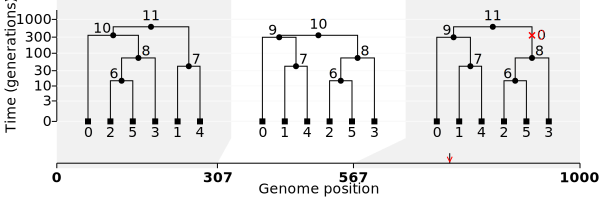

In [4]:
ts.draw_svg(
    y_axis=True,
    y_gridlines=True,
    time_scale="log_time",
    y_ticks=[0, 3, 10, 30, 100, 300,1000],
)

Each tree records the lines of descent along which a piece of DNA has been
inherited (ignore for the moment the red symbols, which represent a mutation).
For example, the first tree tells us that DNA from ancestral genome 7 duplicated
to produce two lineages, which ended up in genomes 1 and 4, both of which exist in the
current population. In fact, since this pattern is seen in all trees, these particular
lines of inheritance were taken by all the DNA in this 1000 base pair genome.


(sec_terminology_nodes)=

### Nodes

Trees in a tree sequence are represented in a slightly unusual way.
In the majority of libraries dealing with trees, each node is represented
as an object in memory and the relationship between nodes as pointers between these
objects. In tree sequences, however, all nodes, both internal and terminal,
are represented by an **integer ID**, unique over the entire tree sequence, and which exists
at a specific point in time. A branch point in any of the trees is associated with
an *internal node*, representing an ancestor in which a single DNA
sequence was duplicated (in forwards-time terminology) or in which multiple sequences
coalesced (in backwards-time terminology). 


(sec_terminology_nodes_samples)=

#### Sample nodes

The tip (leaf) nodes of the tree are usually marked as *sample nodes*, plotted as square
symbols in the visualization. Sample nodes are the focal nodes in a tree sequence; they
normally represent genomes from which we have obtained data (i.e. which we have "sampled"),
and which therefore have a fully known genetic sequence. There are 6 sample nodes,
labelled $0..5$, and also 6 non-sample nodes, labelled $6..11$, in the tree sequence above:

In [5]:
print("There are", ts.num_nodes, "nodes, of which", ts.num_samples, "are sample nodes")

There are 12 nodes, of which 6 are sample nodes


(sec_terminology_edges)=

### Edges

In an evolutionary tree, the connections between nodes are conventionally referred to as
"branches". In a tree sequence, we instead refer to directional connections between nodes
as _edges_, emphasizing that they usually persist across multiple trees. Thus each of the
three trees in the example above has a branch from node 7 to node 1, but those three
branches represent just a single edge.

Each edge is associated with a parent node ID and a child node ID. The time of the parent
node must be
strictly greater than the time of the child node, and the difference in these times is
sometimes referred to as the "length" of the edge. Since trees in a tree sequence are
usually taken to represent marginal trees along a genome, as well as the time dimension
each edge also has a genomic _span_, defined by a *left* and a *right* position
along the genome. There are 15 edges in the tree sequence above. Here's an example of
one of them:

In [6]:
print("There are", ts.num_edges, "edges, one of which is:\n ", ts.edge(10))

There are 15 edges, one of which is:
  Edge(left=307.0, right=567.0, parent=10, child=9, metadata=b'', id=10)


(the `metadata` value is discussed below)

:::{note}
The *number of edges* largely determines the entire size of a tree sequence file. Edges
essentially encode ancestral information, and the number in a tree sequence can
be used as a rough measure of many things such as the compressibility of a simulation,
the speed with which analyses are likely to run, or even the effectiveness of ancestral
inference. To give some sense of scale, a basic inferred tree sequence of human
chromosome 20 in the UK Biobank dataset of a million genomes consists of 62 million edges
which define 16 thousand trees; the uncompressed tree sequence takes 2.1 gigabytes of
disk space, and it takes of the order of a few seconds to iterate over all the trees.
:::

(sec_terminology_trees_and_tree_sequences)=

### Trees and tree sequences

The combination of nodes and edges results in a tree sequence. This can be visualized,
as in the drawing above, as a set of correlated trees. The
sample nodes, $0..5$ in the drawing, are present in all the trees (since we have their
full genomes), but the other nodes, such as node $9$, need not be: indeed in larger
tree sequences they are rarely so.

In tree sequence terminology, we don't explictly keep track of where nodes
start and end. Only edges (not nodes) possess a genomic span. So for example, this tree
sequence is defined using edges like $(7\rightarrow1)$ which span the entire genome,
edges like $(11\rightarrow10)$ which only span the leftmost section of the genome, and
edges like $(11\rightarrow8)$ which span the rightmost part of the genome. Every time an
edge changes it creates a new tree; the location of the change is known as a _breakpoint_:

In [7]:
breakpoints = ts.breakpoints(as_array=True)
print("There are", ts.num_trees, "trees, associated with breakpoints", breakpoints)

There are 3 trees, associated with breakpoints [   0.  307.  567. 1000.]


::::{margin}
More details about these and related methods are given in the {ref}`sec_analysing_trees`
and {ref}`Getting started<sec_tskit_getting_started>` tutorials.
::::

Note that in keeping with the reliance on node numbers (rather than objects), information
about the relationships between nodes in a tree is obtained using their **integer IDs**.
In the Python API, for instance, the {meth}`TreeSequence.first`
method will return the first tree, which then provides basic methods to obtain
information about (say) node $7$, including the IDs of its parent and child nodes:

In [8]:
first_tree = ts.first()
parent_of_7 = first_tree.parent(7)
children_of_7 = first_tree.children(7)
print("Node 7's parent is", parent_of_7, "and childen are", children_of_7, "in the first tree")

Node 7's parent is 11 and childen are (1, 4) in the first tree


(sec_terminology_individuals_and_populations)=

### Individuals and populations

Sometimes we know that one or more nodes belong to a particular
*{ref}`individual<tskit:sec_nodes_or_individuals>`*. For example,
most organisms are diploid, so if we sequence the DNA from an individual we are likely to
obtain two copies of each autosomal chromosome. The tree with six sample nodes above
could therefore represent the result of sampling three diploid individuals from a larger
population. The tree sequence can keep track of the individuals in which nodes reside,
and store specific information about them (such as the individuals' spatial location)
as well as arbitrary {ref}`metadata <sec_metadata>` (such as a name). In this particular
tree sequence the sample nodes are indeed associated with three named diploid
individuals: ``Ada``, ``Bob`` and ``Cat``.

In [9]:
print(f"There are {ts.num_individuals} individuals defined in the tree sequence:")
for individual in ts.individuals():
    print("*", f"Individual {individual.id}: metadata={individual.metadata}")

There are 3 individuals defined in the tree sequence:
* Individual 0: metadata={'name': 'Ada'}
* Individual 1: metadata={'name': 'Bob'}
* Individual 2: metadata={'name': 'Cat'}


Adding these individual names to the sample node labels show that indeed, each of the
three individuals has 2 sample nodes (note that these 2 nodes do not always cluster
together in the trees, as the original simulation was of a randomly mating population)

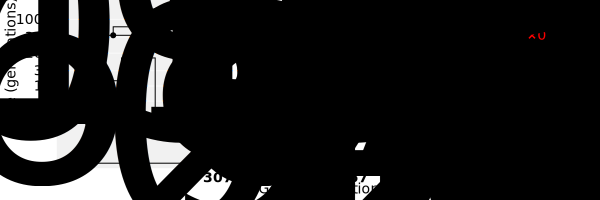

In [10]:
node_labels = {node.id: str(node.id) for node in ts.nodes()}
for n in ts.samples():
    node_labels[n] = f"{n} ({ts.individual(ts.node(n).individual).metadata['name']})"
styles = (
    ".node > .lab {font-size: 70%}"
    ".leaf > .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
)
ts.draw_svg(
    node_labels=node_labels,
    style=styles,
    y_axis=True,
    y_gridlines=True,
    time_scale="log_time",
    y_ticks=[0, 3, 10, 30, 100, 300,1000],
)

In the same way that nodes can be associated with a specific individual, nodes can also
be associated with a larger _population_. In this example, there is only one population
(to which all the nodes belong):

In [11]:
print(f"{ts.num_populations} population(s) defined:")
for population in ts.populations():
    print("*", population)

1 population(s) defined:
* Population(id=0, metadata={'description': 'British from England and Scotland', 'name': 'GBR'})


(sec_terminology_mutations_and_sites)=

### Mutations and sites

In {program}`tskit`, _mutations_ occur at specific, defined _sites_. A mutation is
positioned above a particular node (specified by the node ID), occurs at a particular
site (specified by a site ID), and involves a change of allelic state to a defined
{attr}`~Mutation.derived_state`. A mutation therefore can be specified something like
this:

In [12]:
print(f"{ts.num_mutations} mutation(s) in the tree sequence:")
for mutation in ts.mutations():
    print("*", mutation)

1 mutation(s) in the tree sequence:
* Mutation(id=0, site=0, node=8, derived_state='G', parent=-1, metadata=b'', time=nan, edge=12)


The mutation can have a {attr}`~Mutation.time` or if, as in this case, the times of
mutations in the tree sequence are unknown, all mutations can have the special NaN value
{data}`tskit.UNKNOWN_TIME`. Notice that the genomic position of the mutation is not
included. Instead, that is a property of the _site_ to which the mutation refers, in
this case, site ID 0 (which happens to be at position 751):

In [13]:
print(ts.site(0))  # For convenience, the Python API also returns the mutations at the site

Site(id=0, position=751.0, ancestral_state='T', mutations=[Mutation(id=0, site=0, node=8, derived_state='G', parent=-1, metadata=b'', time=nan, edge=12)], metadata=b'')


In the plot above, since the the only mutation is above node 8 in the last tree, and has
a {attr}`~Mutation.derived_state` of "G", we know that the samples descending from node
8 in the last tree (sample genomes 2, 3, and 5) have a "G" at {attr}`~Site.position` 751,
while the others have the {attr}`~Site.ancestral_state` of "T". This means that Ada is
homozygous for "T", Bob is homozygous for "G", and Cat is heterozygous "T/G".
In other words the ancestral state and the details of any mutations at that site,
when coupled with the tree topology at the site {attr}`~Site.position`, is sufficient to
define the allelic state possessed by each sample.

Note that even though the genome is 1000 base pairs long, the tree sequence only contains
a single site, because we usually only bother defining *variable* sites in a tree
sequence (e.g. positions seen in studies to have samples possessing different alleles at
that genomic location). It is perfectly possible to have a site with no mutations
(or silent mutations) --- i.e. a "monomorphic" site --- but such sites are not normally
used in further analysis.


(sec_terminology_provenance)=

### Provenance

The history of the tree sequence is recorded in a set of provenance entries. That
includes what produced it, and what operations have been done to it and when. For
instance, if it was produced by {ref}`simplifying<sec_simplification>` a tree
sequence produced by the msprime simulator, the first provenance entry would record the
call to msprime that produced it, and the second the call to
{meth}`~TreeSequence.simplify` that was done on the result. Ideally, the list of
provenance entries are sufficient to exactly recreate the tree sequence, but this
is not always possible.


(sec_concepts)=

## Concepts

There are some basic population genetic concepts which can be helpful with thinking about
tree sequences. For reference, here is the tree sequence topology that we have been using:

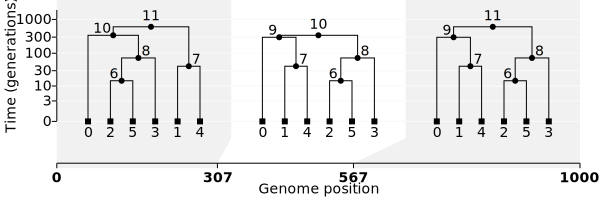

In [14]:
ts.draw_svg(
    y_axis=True,
    y_gridlines=True,
    time_scale="log_time",
    y_ticks=[0, 3, 10, 30, 100, 300,1000],
    style=".mut, .site {display: none}",
)

Note that all these trees show strictly bifurcating splits, but this does not need to be
the case for tree sequences in general. In particular, where tree sequences have been
created by the multiple-merger coalecent process, or in tree
sequences that have been inferred from real data, it is possible to have a parent node
with 3 or more children in a particular tree (these are known as *polytomies*).


(sec_concepts_sprs)=

### Tree changes, ancestral recombinations, and SPRs

The reason that tree sequences are efficient is that very few edges
{ref}`change from tree to tree<fig_what_is_edge_diffs>`. More specifically, recombination
results in adjacent trees that differ by only a few "tree edit" or SPR
(subtree-prune-and-regraft) operations. This is seen in the example tree sequence above.

In this (simulated) tree sequence, each tree differs from the next by a single SPR.
The subtree defined by node 7 in the first tree has been pruned and regrafted onto the
branch between 0 and 10, to create the second tree. The second and third trees have the
same topology, but differ because their ultimate coalesence happened in a different
ancestor (easy to spot in a simulation, but hard to detect in real data). This is also
caused by a single SPR: looking at the second tree, either the subtree below node 8 or
the subtree below node 9 must have been pruned and regrafted higher up on the same
lineage to create the third tree. Because this is a fully {ref}`simplified<sec_simplification>`
tree sequence, it is impossible to tell which of these two possible SPRs occurred. To
know this, we would need to have a tree sequence with the exact history of recombinations
recorded (see below).

In general, each detectable recombination occurring in ancestral history results in a
single SPR in the tree sequence. If recombination breakpoints occurs at unique
positions (an "infinite sites" model of breakpoints), then the number of trees in a tree
sequence equals the number of ancestral recombination events plus one. If recombinations
can occur at the same physical position (e.g. if the genome is treated as a set of
discrete integer positions, as in the simulation that created this tree sequence) then
moving from  one tree to the next in a tree sequence might require multiple SPRs if
there are multiple, overlaid ancestral recombination events.

(sec_concepts_args)=

### Tree sequences and ARGs

Much of the literature on ancestral inference concentrates on the Ancestral Recombination
Graph, or ARG, in which details of the position and potentially the timing of
recombination events are explictly stored. Although a tree sequence *can* represent such
an ARG, by incorporating nodes that represent recombination events (see the
{ref}`sec_args` tutorial), this is not normally done for two reasons:

1. Many recombination events are undetectable from sequence data, and even if they are
   detectable, they can be logically impossible to place in the genealogy (as in the
   second SPR example above).
2. The number of recombination events in the genealogy can grow to dominate the total
   number of nodes in the total tree sequence, without actually contributing to the
   realised sequences in the samples. In other words, recombination nodes are redundant
   to the storing of genome data.

Therefore, compared to an ARG, you can think of a standard tree sequence as simply
storing the trees *created by* recombination events, rather than attempting to record the
recombination events themselves. The actual recombination events can be sometimes be
inferred from these trees but, as we have seen, it's not always possible. Here's another
way to put it:

> "an ARG encodes the events that occurred in the history of a sample,
> whereas a tree sequence encodes the outcome of those events"
> ([Kelleher _et al._, 2019](https://doi.org/10.1534/genetics.120.303253))


### Tables

The underlying data in a tree sequence are stored in a collection of tables. Details of
these tables, as well as some basic properties of the tree sequence which they encode,
are shown when printing a tree sequence to the screen:

In [15]:
ts  # or use `print(ts)` for the plain text representation

There is a separate API for dealing with a tree sequence as a collection of tables,
which can be useful for dealing with large datasets, and is needed if you want to
{ref}`edit<sec_tables_editing>` an existing tree sequence. This is covered in
the {ref}`sec_tables` tutorial.